In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import pprintpp
pprintpp.monkeypatch() 

import re
import multiprocessing
from collections import Counter
import itertools
import pickle
import json
from IPython.display import display as disp
from sklearn.tree import export_graphviz 
from sklearn.tree import DecisionTreeClassifier
import graphviz 
import subprocess

import numpy as np
# import bottleneck as bn
import pandas as pd
import networkx as nx
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.cm.rocket.set_bad([0.01060815, 0.01808215, 0.10018654])
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
%matplotlib inline
sns.set_palette(colorcycle)

# import warnings
# warnings.simplefilter("ignore", category=DeprecationWarning)
# warnings.simplefilter("ignore", category=mpl.cbook.mplDeprecation)
# warnings.simplefilter("ignore", category=UserWarning)


from speclib import misc, loaders, graph, plotting

pd.set_option('display.max_rows', 55)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=145)

mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['figure.figsize'] = [12, 7] 

# import pixiedust

/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/pprintpp/__init__.py:171: UserWarning: 'pprint' has already been imported; monkeypatching won't work everywhere.
  warnings.warn("'pprint' has already been imported; monkeypatching "


# Plot decision tree

Make a decision tree plot for the report

In [2]:
data_path = '../../allan_data/DataPredictMovement_half.p'
x, y = np.load(data_path)
x = x
xx_tr = x[:8000, :] 
yy_tr = y[:8000] 

In [3]:
graphs = list()
for name, depth, max_leaf_nodes in [('shallow', 2, 8), ('deep', 16, 60)]:
    tree = DecisionTreeClassifier(max_depth=depth, class_weight=None,
                                  criterion='entropy', max_leaf_nodes=max_leaf_nodes) 

    tree.fit(xx_tr, yy_tr)

    columns = [f"{cha}_{qrt}" for cha in "Call SMS GPS Bluetooth".split() for qrt in range(1, 9)] 

    dot_data = export_graphviz(tree, out_file=None, feature_names=columns, class_names=["Didn't move", "Did move"],
                               filled=True, impurity=True, leaves_parallel=True, rounded=True,
                               special_characters=True)
    dot_data = dot_data.replace('helvetica', '"CMU Sans Serif"') 
    with open(f'decision_tree_example_{name}.dot', 'w') as fid:
        fid.write(dot_data)

    graphs.append(graphviz.Source(dot_data))

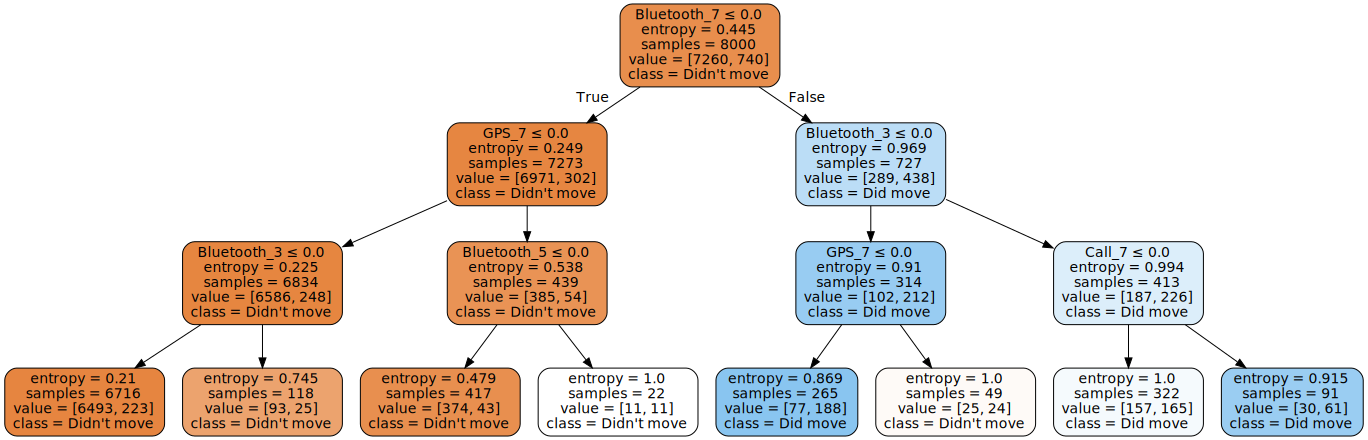

In [4]:
graphs[0]

In [5]:
print(subprocess.call(
     'dot -Tpdf decision_tree_example_shallow.dot -o figs/decision_tree_example_shallow.pdf',
      shell=True))
print(subprocess.call(
     'dot -Tpdf decision_tree_example_deep.dot  -o figs/decision_tree_example_deep.pdf',
      shell=True)) 

0
0


In [6]:
with open('userMovement_rf_coarse.pkl', 'br') as fid:
    rfc = pickle.load(fid) 
with open('userMovement_rf_finer.pkl', 'br') as fid:
    rff = pickle.load(fid)

In [7]:
rfc.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
     ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [8]:
rfc.validation_auc_score

0.8589634875117511

In [9]:
rfc.best_score_

0.8584558041362306

In [10]:
rfc.validation_auc_score - rfc.best_score_

0.0005076833755205401

In [11]:
est = rfc.best_estimator_.steps[1][1] 

In [12]:
est.feature_importances_.shape

(32,)

In [13]:
tr0 = est.estimators_[0]
columns = [f"{cha}{qrt}" for cha in "CSGB" for qrt in range(1, 9)]
feature_importance = np.zeros((len(est.estimators_), len(tr0.feature_importances_)))
for i, tr in enumerate(est.estimators_):
    feature_importance[i, :] = tr.feature_importances_ 
fi = pd.DataFrame(feature_importance, columns=columns)

In [14]:
fi = fi[fi.mean().sort_values(ascending=False).index] * 100

In [15]:
fi.head() 

,B7,B3,G7,G3,S7,...,C6,S5,S1,C5,C1
0,44.911739,35.679640,0.976231,1.277292,1.337043,...,0.254748,0.172246,0.279923,0.171319,0.181755
1,77.268876,2.934542,2.970511,0.707058,0.798130,...,0.249481,0.196723,0.159604,0.162971,0.181244
2,75.404045,4.641294,2.561013,2.451872,0.564517,...,0.298924,0.180989,0.173417,0.176871,0.152236
3,52.733662,33.823561,0.718640,1.674308,0.695750,...,0.220801,0.222329,0.176601,0.183128,0.201160
4,80.813430,3.792741,1.388992,2.500923,0.651349,...,0.198659,0.179466,0.188586,0.184450,0.172293


In [16]:
cat_dct = {'B': 0.0, 'C': 1.0, 'G': 2.0, 'S': 3.0} 
cat = pd.Series(fi.columns.str[0].map(lambda s: cat_dct[s]), index=fi.columns) 

In [17]:
fi_agg = pd.DataFrame([fi.mean(), fi.std(), cat], index=['Feature importance', 'std', 'cat']).T
fi_agg.head() 

,Feature importance,std,cat
B7,60.635047,15.640734,0.0
B3,14.030777,12.831086,0.0
G7,5.376852,5.762392,2.0
G3,3.488555,4.171598,2.0
S7,1.740810,2.083635,3.0


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


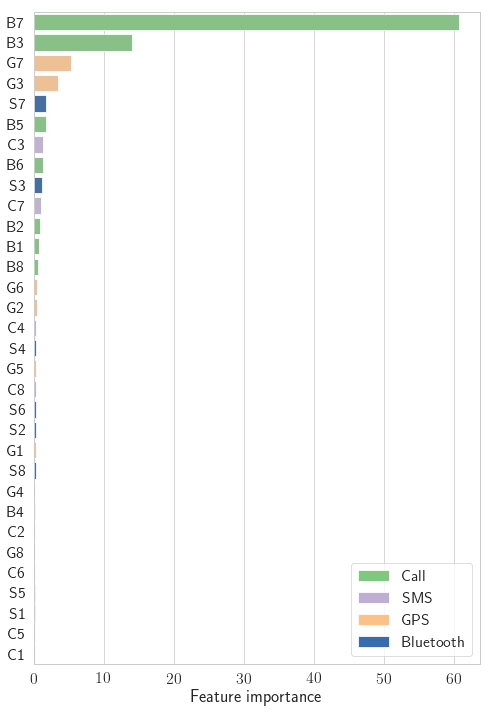

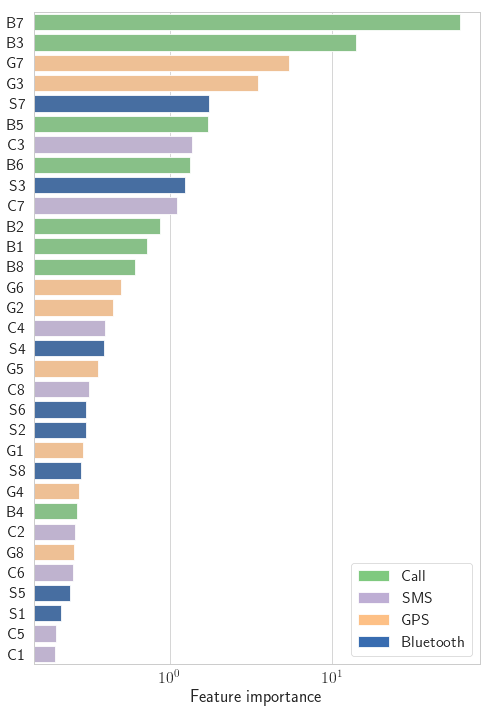

In [18]:
for log_switch in [False, True]:
    fig, ax = plt.subplots(figsize=(8, 12))
    bars = sns.barplot(data=fi_agg, x='Feature importance', y=fi_agg.index,
                       hue='cat', dodge=False, ax=ax, log=log_switch, orient='h')
    custom_lines = [mpl.patches.Patch(facecolor=colorcycle[0]),
                    mpl.patches.Patch(facecolor=colorcycle[1]), 
                    mpl.patches.Patch(facecolor=colorcycle[2]),
                    mpl.patches.Patch(facecolor=colorcycle[3])]
    ax.legend(custom_lines, ["Call", "SMS", "GPS",
                             "Bluetooth"], loc="lower right")
    if log_switch:
        fig.savefig('figs/random_forest_important_features_logarithmic.pdf')
    else:
        fig.savefig('figs/random_forest_important_features_linear.pdf') 

Text(0,0.5,'Tree')

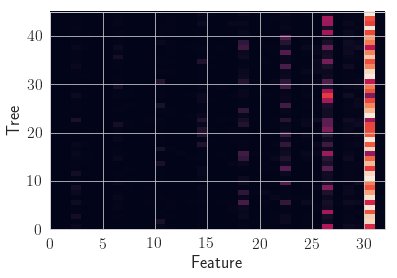

In [19]:
fig, ax = plt.subplots()
ax.pcolorfast(feature_importance)
ax.set_xlabel('Feature')
ax.set_ylabel('Tree')

In [20]:
tr0.tree_.node_count

31331

In [21]:
n_tree_nodes = np.array([tr.tree_.node_count for tr in est.estimators_])

Text(0,0.5,'\\# trees')

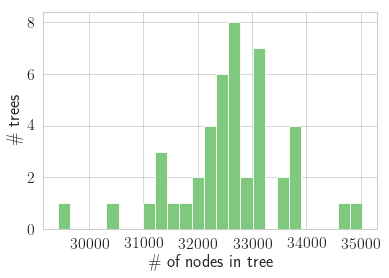

In [22]:
fig, ax = plt.subplots()
ax.hist(n_tree_nodes, 25)
ax.set_xlabel(r"\# of nodes in tree")
ax.set_ylabel(r"\# trees")

In [23]:
kw_rx = re.compile(r'(?P<key>\S+) = (?P<value>.+)')
op_rx = re.compile(r'(?P<key>\S+) (?P<operator>\S=) (?P<value>.+)')
ed_rx = re.compile(r'^(\d+) -> (\d+)') 

In [24]:
x_rx = re.compile(r'X\[(\d{1,2})\]')

def parse_label(label):
    m = x_rx.search(label)
    if m:
        return int(m.groups()[0]) 
    return None

In [25]:
def tree2nxgraph(tr):
    dot_file = export_graphviz(tr, out_file=None)
    nodes, edges = list(), list()
    for line in dot_file.split('\n'):
        try:
            if '[label=' in line:
                start = line.find('"') + 1
                end = line.find('"', start)
                lbl = line[start:end]
                nodes.append((int(line.split(' ', maxsplit=1)[0]), parse_label(lbl)))
                continue
            elif '->' in line:
                a, b = ed_rx.search(line).groups()
                edges.append((int(a), int(b)))
            else:
                # print("Didn't read", repr(line))
                pass
        except:  # noqa
            print(line)
    g = nx.DiGraph()
    for nid, attr in nodes:
        g.add_node(nid, nodeattr=attr)
    g.add_edges_from(edges)
    return g, nodes

In [ ]:
def tree_stat_summary(g, nodes):
    outdeg_arr     = np.array(g.out_degree)
    outdeg_count   = pd.value_counts(outdeg_arr[:, 1])
    node_splits    = outdeg_arr[(outdeg_arr[:, 1] == 2), 0]
    dist_from_root = [nx.shortest_path_length(g, 0, nd) for nd in node_splits]


    nodeattr  = nx.get_node_attributes(g, 'nodeattr')
    splits    = np.array(nodes)[:, 1]
    splits_vc = pd.value_counts(splits, dropna=False)

    narr = np.array(nodes)
    narr_vc = pd.value_counts(narr[:, 1])

    root_distance = np.zeros((16, 32), dtype=int)
    rootdf = list()
    for i, (nd, sv) in enumerate(((nd, sv) for (nd, sv) in nodes if g.out_degree[nd] == 2)):
        dst = nx.shortest_path_length(g, 0, nd)
        root_distance[dst, sv] += 1
        rootdf.append((nd, sv, dst))
    rootdf = pd.DataFrame(rootdf, columns="node variable distance".split())
    return outdeg_count, dist_from_root, splits_vc, root_distance, rootdf


In [ ]:
root_distance_agg = np.zeros((16, 32))
splits_vc_agg = pd.Series(index=list(range(32)) + [np.NaN])
dist_from_root_agg = list()
for tr in est.estimators_:
    g, nodes = tree2nxgraph(tr)
    
    outdeg_count, dist_from_root, splits_vc, root_distance, rootdf = tree_stat_summary(g, nodes) 
    
    root_distance_agg += root_distance
    splits_vc_agg += splits_vc 
    dist_from_root_agg.append(dist_from_root)

In [ ]:
fig, ax = plt.subplots() 
data = root_distance_agg + 1
pc = ax.pcolor(root_distance_agg, norm=mpl.colors.LogNorm(), cmap=sns.cm.rocket)
fig.colorbar(pc)
xticks_incices = np.arange(0, 32, 2) 
ax.set_xticks(xticks_incices + 0.5)
ax.set_xticklabels([columns[i].upper() for i in xticks_incices]); 
fig.savefig('figs/festure_split_distance_from_root.pdf')

In [ ]:
fig, ax = plt.subplots()
x = np.arange(root_distance_agg.shape[1])
y = root_distance_agg.mean(axis=0)/32
std = root_distance_agg.std(axis=0)/np.sqrt(32)/32
ax.fill_between(x, y-std, y+std, alpha=0.3)
ax.plot(x, y, '-o')
xticks_incices = np.arange(0, 32, 2) 
ax.set_xticks(xticks_incices)
ax.set_xticklabels([columns[i].upper() for i in xticks_incices])
fig.savefig('figs/mean_feature_split_distance_from_root.pdf')

In [ ]:
def tree_stat_summary(g, nodes):
    outdeg_arr     = np.array(g.out_degree)
    outdeg_count   = pd.value_counts(outdeg_arr[:, 1])
    node_splits    = outdeg_arr[(outdeg_arr[:, 1] == 2), 0]
    dist_from_root = [nx.shortest_path_length(g, 0, nd) for nd in node_splits]


    nodeattr  = nx.get_node_attributes(g, 'nodeattr')
    splits    = np.array(nodes)[:, 1]
    splits_vc = pd.value_counts(splits, dropna=False)

    narr = np.array(nodes)
    narr_vc = pd.value_counts(narr[:, 1])

    root_distance = np.zeros((16, 32), dtype=int)
    rootdf = list()
    for i, (nd, sv) in enumerate(((nd, sv) for (nd, sv) in nodes if g.out_degree[nd] == 2)):
        dst = nx.shortest_path_length(g, 0, nd)
        root_distance[dst, sv] += 1
        rootdf.append((nd, sv, dst))
    rootdf = pd.DataFrame(rootdf, columns="node variable distance".split())
    return outdeg_count, dist_from_root, splits_vc, root_distance, rootdf


outdeg_count, dist_from_root, splits_vc, root_distance, rootdf = tree_stat_summary(g, nodes) 

In [ ]:
print(outdeg_count) 

In [ ]:
fig, ax = plt.subplots()
plt.plot(pd.value_counts(dist_from_root)[::-1]) 

In [ ]:
print(splits_vc)

In [ ]:
fig, ax = plt.subplots()
sns.heatmap(data=np.log2(root_distance + 1))
ax.set_xticks(np.arange(32) + 0.5)
ax.set_xticklabels(columns); 

In [ ]:
x.shape, y.shape

In [ ]:
fig, ax = plt.subplots()
x = np.arange(root_distance.shape[1])
y = root_distance.mean(axis=0)
std = root_distance.std(axis=0)/np.sqrt(root_distance.shape[0])
ax.fill_between(x, y-std, y+std, alpha=0.3)
ax.plot(x, y, '-o')
ax.set_xticks(np.arange(32))
ax.set_xticklabels(columns); 